In [20]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""
import os 
# Set working directory
#Get working directory
print(os.getcwd())
os.chdir("/Users/mariotuci/Desktop/Latent-Communication/latent-communication/")

/Users/mariotuci/Desktop/Latent-Communication/latent-communication


In [21]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


In [22]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping == 'Linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping == 'Affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping == 'NeuralNetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [43]:
##############################################
#Specify here which files you want to use

folder1 = "models/checkpoints/VAE/FMNIST/"
folder2 = "models/checkpoints/VAE/FMNIST/"
dataset="FMNIST"
number_samples = [10,50]
mapping_list = ["Linear"]
lamda_list = [0,0.1]
sampling_strategy = "equally"
filter = '_8_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all the possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()
# Result of all the combinations 
results_list = []
# Result for the classes 
results_list_classes = []
# Result for each sample 
results_list_samples = []
# Get for each class the corresponding indices 
class_indices = {i: np.where(labels.numpy() == i)[0] for i in range(n_classes)}
# Get the corresponding class for each index
# Indices are the keys and the values are the classes
indices_class = {v: k for k, v in n_classes.items()}

#indices_class = {v: k for k, v in class_indices.items()}




for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  print(file1)
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + file2)
  #Load mapping
  mapping_path = f'results/transformations/mapping_files/{name_model2}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)
  #Model1 output
  decoded_left = model1.decode(torch.tensor(latent_left, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  # Model2 output
  decoded_right = model2.decode(torch.tensor(latent_right, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  #Get stitched output
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  mse_loss = criterion(torch.tensor(decoded_transformed),images).item()
  # MSE loss for the model1 
  mse_loss_model1 = criterion(torch.tensor(decoded_left),images).item()
  # MSE loss for the model2
  mse_loss_model2 = criterion(torch.tensor(decoded_right),images).item()
  #ssim_loss = ssim(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  #psnr_loss = psnr(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  results_list.append({
    "dataset": dataset,
    "model1": file1,
    "model2": file2,
    "mapping": mapping_name,
    "lambda": lamda,
    "num_samples": num_samples,
    "MSE_loss": mse_loss,
    "MSE_loss_model1": mse_loss_model1,
    "MSE_loss_model2": mse_loss_model2,
    "class": None
    })
  
  # For all classes calculate the mse loss per class
  for i in range(n_classes):
    indices = class_indices[i]
    # Model1 output for class i 
    decoded_left_class = decoded_left[indices]
    # Model2 output for class i
    decoded_right_class = decoded_right[indices]

    # Stiched output for class i
    decoded_transformed_class = decoded_transformed[indices]
    # Images per class i
    images_class = images[indices]
    # Stitched
    mse_loss_class = criterion(torch.tensor(decoded_transformed_class),images_class).item()
    # Get the mse loss for the model1
    mse_loss_model1 = criterion(torch.tensor(decoded_left_class),images_class).item()
    # Get the mse loss for the model2
    mse_loss_model2 = criterion(torch.tensor(decoded_right_class),images_class).item()

    results_list_classes.append({
      "dataset": dataset,
      "model1": file1,
      "model2": file2,
      "mapping": mapping_name,
      "lambda": lamda,
      "num_samples": num_samples,
      "MSE_loss": mse_loss_class,
      "MSE_loss_model1": mse_loss_model1,
      "MSE_loss_model2": mse_loss_model2,
      "class": i,
      })

results_class = pd.DataFrame(results_list_classes)
results = pd.DataFrame(results_list)

  0%|          | 0/24 [00:00<?, ?it/s]

FMNIST_VAE_8_3.pth


/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_21973/3736275152.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  4%|▍         | 1/24 [00:03<01:24,  3.66s/it]

FMNIST_VAE_8_3.pth


  8%|▊         | 2/24 [00:05<00:55,  2.54s/it]

FMNIST_VAE_8_3.pth


 12%|█▎        | 3/24 [00:07<00:45,  2.17s/it]

FMNIST_VAE_8_3.pth


 17%|█▋        | 4/24 [00:08<00:39,  1.96s/it]

FMNIST_VAE_8_3.pth


 21%|██        | 5/24 [00:10<00:35,  1.84s/it]

FMNIST_VAE_8_3.pth


 25%|██▌       | 6/24 [00:12<00:31,  1.77s/it]

FMNIST_VAE_8_3.pth


 29%|██▉       | 7/24 [00:13<00:29,  1.72s/it]

FMNIST_VAE_8_3.pth


 33%|███▎      | 8/24 [00:15<00:27,  1.69s/it]

FMNIST_VAE_8_2.pth


 38%|███▊      | 9/24 [00:16<00:24,  1.67s/it]

FMNIST_VAE_8_2.pth


 42%|████▏     | 10/24 [00:18<00:23,  1.65s/it]

FMNIST_VAE_8_2.pth


 46%|████▌     | 11/24 [00:20<00:21,  1.64s/it]

FMNIST_VAE_8_2.pth


 50%|█████     | 12/24 [00:21<00:19,  1.63s/it]

FMNIST_VAE_8_2.pth


 54%|█████▍    | 13/24 [00:23<00:17,  1.63s/it]

FMNIST_VAE_8_2.pth


 58%|█████▊    | 14/24 [00:25<00:16,  1.63s/it]

FMNIST_VAE_8_2.pth


 62%|██████▎   | 15/24 [00:26<00:14,  1.63s/it]

FMNIST_VAE_8_2.pth


 67%|██████▋   | 16/24 [00:28<00:13,  1.63s/it]

FMNIST_VAE_8_1.pth


 71%|███████   | 17/24 [00:29<00:11,  1.65s/it]

FMNIST_VAE_8_1.pth


 75%|███████▌  | 18/24 [00:31<00:09,  1.66s/it]

FMNIST_VAE_8_1.pth


 79%|███████▉  | 19/24 [00:33<00:08,  1.65s/it]

FMNIST_VAE_8_1.pth


 83%|████████▎ | 20/24 [00:34<00:06,  1.64s/it]

FMNIST_VAE_8_1.pth


 88%|████████▊ | 21/24 [00:36<00:04,  1.64s/it]

FMNIST_VAE_8_1.pth


 92%|█████████▏| 22/24 [00:38<00:03,  1.66s/it]

FMNIST_VAE_8_1.pth


 96%|█████████▌| 23/24 [00:39<00:01,  1.68s/it]

FMNIST_VAE_8_1.pth


100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


In [33]:
#Save results somewhere: TODO change path
# Results General 

path_result="results_stitching.csv"
results.to_csv(path_result)

In [45]:
results

,dataset,model1,model2,mapping,lambda,num_samples,MSE_loss,MSE_loss_model1,MSE_loss_model2,class
0,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,0.871690,0.083489,0.083232,None
1,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.1,10,0.316429,0.083503,0.083239,None
2,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,50,0.119231,0.083487,0.083313,None
3,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.1,50,0.401411,0.083485,0.083268,None
4,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_1.pth,Linear,0.0,10,0.349997,0.083481,0.083420,None
5,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_1.pth,Linear,0.1,10,0.343412,0.083530,0.083444,None
6,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_1.pth,Linear,0.0,50,0.146392,0.083463,0.083428,None
7,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_1.pth,Linear,0.1,50,0.421860,0.083436,0.083477,None
8,FMNIST,FMNIST_VAE_8_2.pth,FMNIST_VAE_8_3.pth,Linear,0.0,10,0.621770,0.083234,0.083480,None
9,FMNIST,FMNIST_VAE_8_2.pth,FMNIST_VAE_8_3.pth,Linear,0.1,10,0.325026,0.083219,0.083615,None


In [46]:
results_class

,dataset,model1,model2,mapping,lambda,num_samples,MSE_loss,MSE_loss_model1,MSE_loss_model2,class
0,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,0.577381,0.079396,0.079628,0
1,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,1.019602,0.051284,0.052468,1
2,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,1.192529,0.083575,0.083629,2
3,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,0.804419,0.079290,0.078778,3
4,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.0,10,1.359533,0.079016,0.078349,4
...,...,...,...,...,...,...,...,...,...,...
235,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0.1,50,0.292196,0.114222,0.114769,5
236,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0.1,50,0.408993,0.082749,0.081984,6
237,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0.1,50,0.357206,0.061903,0.061559,7
238,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0.1,50,0.541495,0.115979,0.116766,8


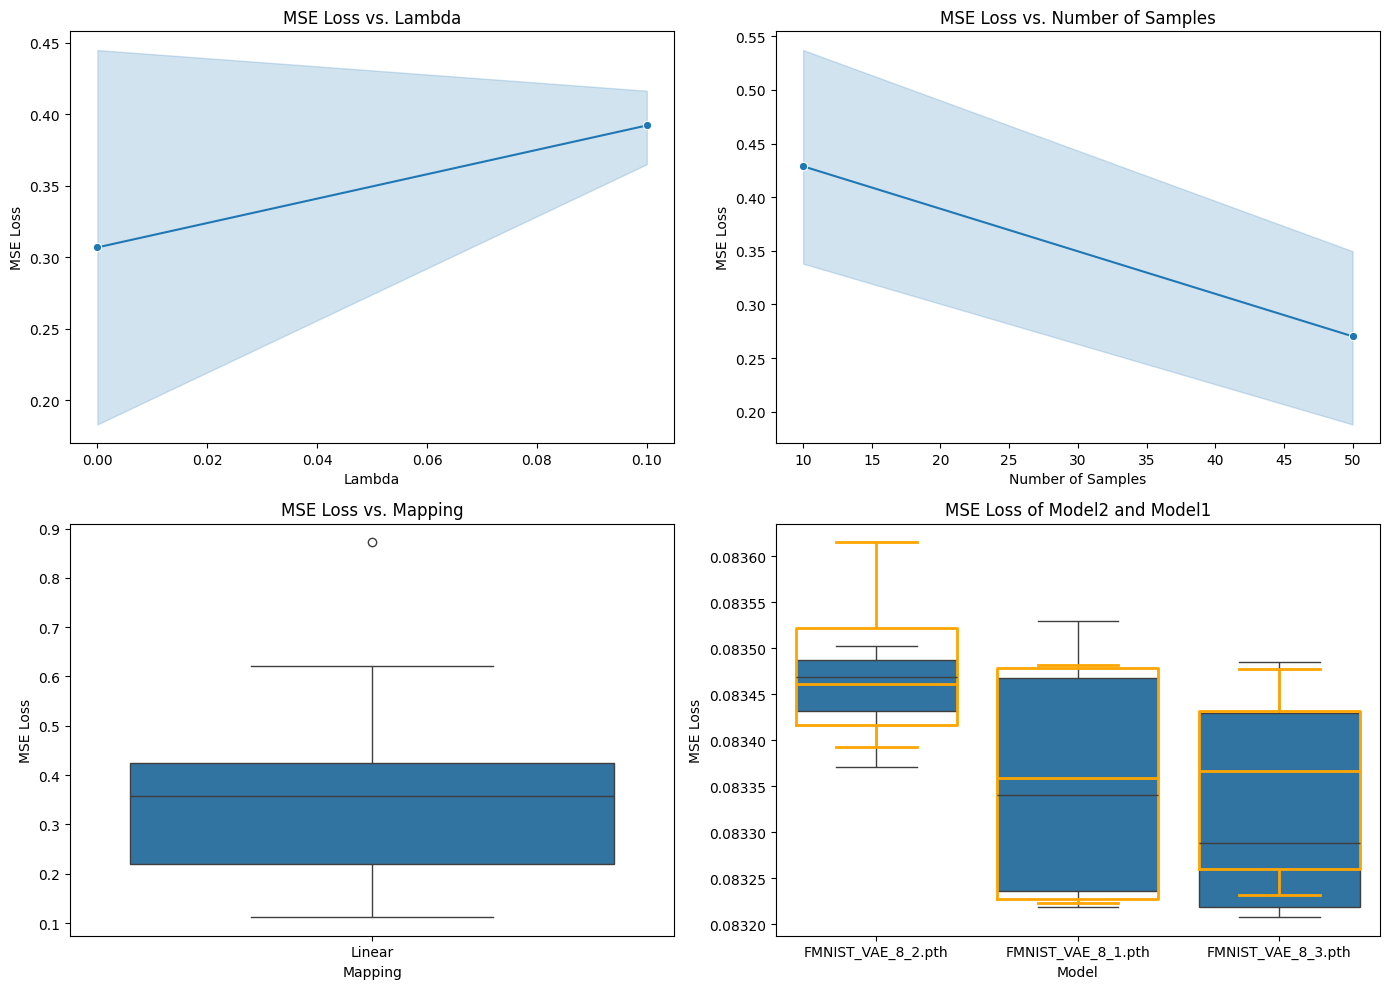

In [60]:
# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. model1 and model2 (as a categorical variable)

plt.subplot(2, 2, 4)
sns.boxplot(data=results, x='model2', y='MSE_loss_model1')
# Change opacity of the boxplot
sns.boxplot(data=results, x='model1', y='MSE_loss_model2', color='orange', fill=None, linewidth=2)

plt.title('MSE Loss of Model2 and Model1')
plt.xlabel('Model')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

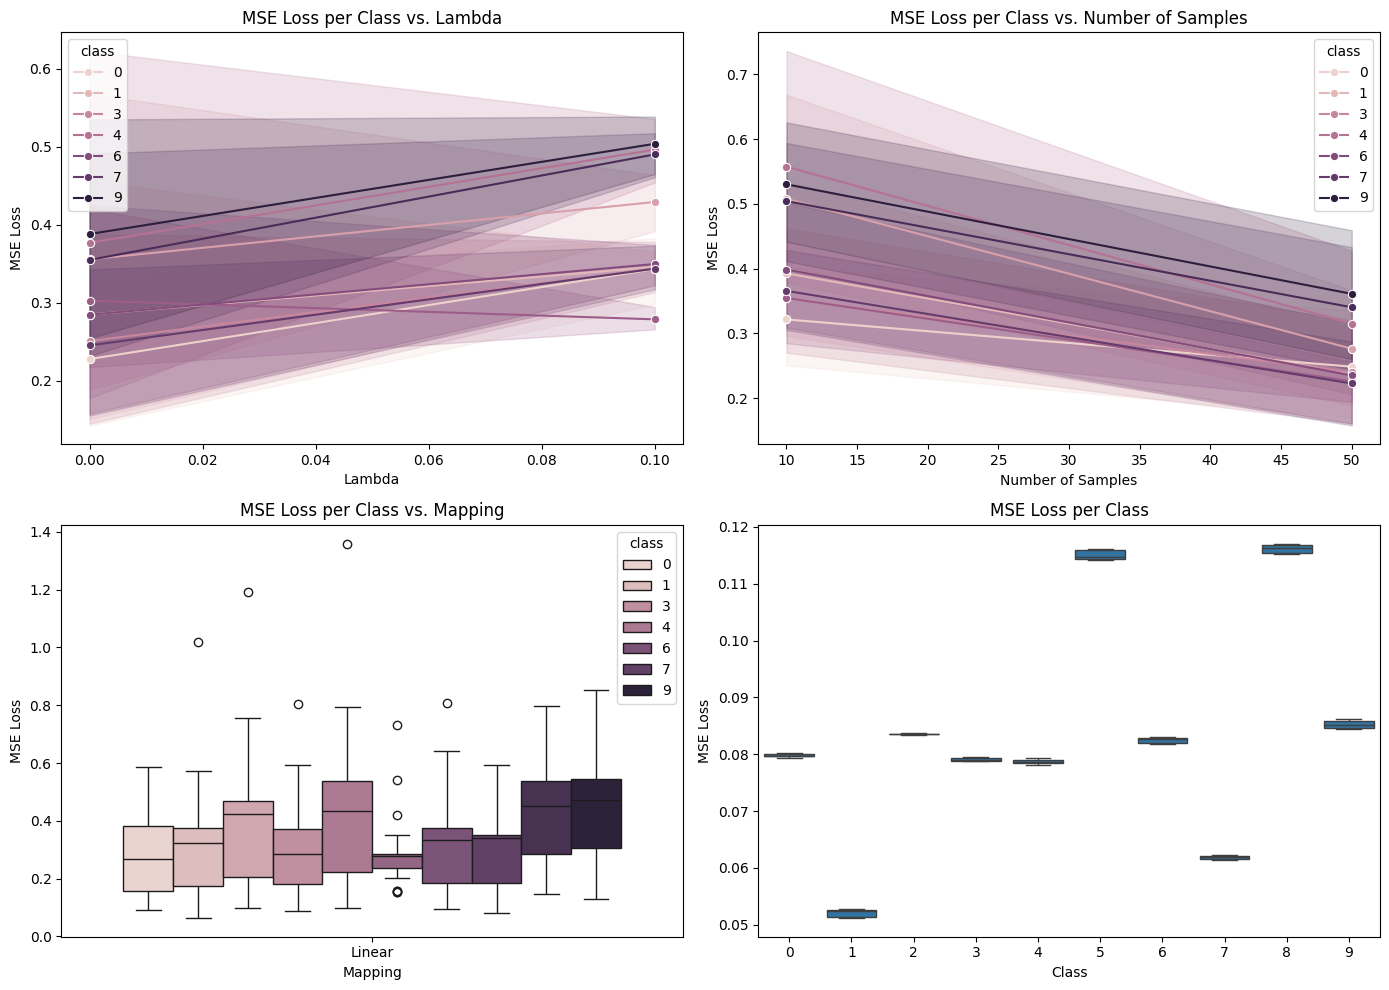

In [55]:
# Use different colors for each class blue

sns.set_palette(sns.color_palette("tab10"))

# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=results_class, x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('MSE Loss per Class vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results_class, x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('MSE Loss per Class vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. mapping
plt.subplot(2, 2, 3)
sns.boxplot(data=results_class, x='mapping', y='MSE_loss', hue='class')
plt.title('MSE Loss per Class vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot class outliers for each class 
plt.subplot(2, 2, 4)
sns.boxplot(data=results_class, x='class', y='MSE_loss_model2')
plt.title('MSE Loss per Class')
plt.xlabel('Class')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

In [67]:
# Latent difference 
print(type(latent_left))
print(type(transformed_latent_space.numpy()))

#latent_difference = latent_left - transformed_latent_space

# Find best Peforming image in terms of MSE loss in the class
best_performing_image = results_class.loc[results_class.groupby('class')['MSE_loss'].idxmin()]

print(best_performing_image)



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
    dataset              model1              model2 mapping  lambda  \
140  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_1.pth  Linear     0.0   
141  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_1.pth  Linear     0.0   
102  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_3.pth  Linear     0.0   
223  FMNIST  FMNIST_VAE_8_1.pth  FMNIST_VAE_8_2.pth  Linear     0.0   
224  FMNIST  FMNIST_VAE_8_1.pth  FMNIST_VAE_8_2.pth  Linear     0.0   
105  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_3.pth  Linear     0.0   
146  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_1.pth  Linear     0.0   
227  FMNIST  FMNIST_VAE_8_1.pth  FMNIST_VAE_8_2.pth  Linear     0.0   
228  FMNIST  FMNIST_VAE_8_1.pth  FMNIST_VAE_8_2.pth  Linear     0.0   
109  FMNIST  FMNIST_VAE_8_2.pth  FMNIST_VAE_8_3.pth  Linear     0.0   

     num_samples  MSE_loss  MSE_loss_model1  MSE_loss_model2  class  
140           50  0.090629         0.079603         0.079949      0  
141           50  0.064002    